<a href="https://colab.research.google.com/github/richi1998/Side_project_prediction_app/blob/main/Project_Old_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 pip install databento

In [ ]:
pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp 'path/to/your/kaggle.json' ~/.kaggle/kaggle.json

cp: cannot stat 'path/to/your/kaggle.json': No such file or directory


In [ ]:
import http.client

conn = http.client.HTTPSConnection("api.dhan.co")

headers = {
    'access-token': "",
    'Accept': "application/json"
}

conn.request("GET", "/trades", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))


{"errorCode":"UNAUTHORIZED","httpStatus":"UNAUTHORIZED","internalErrorCode":"RS-9005","internalErrorMessage":"The token was expected to have 3 parts, but got 1."}


In [ ]:

#import databento as db

#client = db.Live(key="$YOUR_API_KEY")

#client.subscribe(
 #   dataset="GLBX.MDP3",
  #  schema="ohlcv-1s",
   # stype_in="parent",
    #symbols=["ES.FUT", "NQ.FUT"],
#)

#client.add_callback(print)

#client.start()

#client.block_for_close(timeout=10)



In [ ]:
!kaggle datasets download -d bryanb/cac40-stocks-dataset

Dataset URL: https://www.kaggle.com/datasets/bryanb/cac40-stocks-dataset
License(s): CC0-1.0
cac40-stocks-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Assuming the dataset is a CSV file
dataset_path = 'cac40-stocks-dataset.zip'  # Replace with the actual filename


In [ ]:
import zipfile

# Assuming the dataset is downloaded as 'cac40-stocks-dataset.zip'
dataset_path = 'cac40-stocks-dataset.zip'

# Extract to the current working directory (you can change this if needed)
extraction_path = '.'  # Replace with desired extraction directory

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
  zip_ref.extractall(extraction_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [ ]:
df = pd.read_csv('/content/CAC40_stocks_2010_2021.csv', parse_dates=['Date'])
df.head()
df2 = pd.read_csv('/content/CAC40_stocks_2021_2023.csv', parse_dates=['Date'])
df.head()
df3 = pd.read_csv('/content/preprocessed_CAC40.csv', parse_dates=['Date'])


In [ ]:
df

,CompanyName,StockName,High,Low,Open,Close,Volume,Date
0,TechnipFMC,FTI,29.855000,29.075001,29.075001,29.615000,1908400.0,2010-01-04
1,TechnipFMC,FTI,30.270000,29.555000,29.610001,30.125000,2206600.0,2010-01-05
2,TechnipFMC,FTI,30.305000,29.434999,30.040001,30.264999,2724200.0,2010-01-06
3,TechnipFMC,FTI,30.219999,29.715000,30.155001,29.915001,2581000.0,2010-01-07
4,TechnipFMC,FTI,30.500000,29.625000,29.830000,30.450001,3280400.0,2010-01-08
...,...,...,...,...,...,...,...,...
81730,LVMH,MC,53.889999,51.279999,53.689999,51.450001,404700.0,2021-01-26
81731,LVMH,MC,50.779999,48.759998,50.419998,49.369999,688200.0,2021-01-27
81732,LVMH,MC,51.820000,49.639999,49.930000,51.189999,480400.0,2021-01-28
81733,LVMH,MC,51.130001,48.990002,51.099998,49.709999,341000.0,2021-01-29


In [ ]:
df3

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415
...,...,...,...,...,...,...,...,...
97643,97643,Worldline SA,2014-07-04,16.22,16.28,16.29,16.22,NaN
97644,97644,Worldline SA,2014-07-03,16.12,16.28,16.28,16.12,NaN
97645,97645,Worldline SA,2014-07-02,16.22,16.17,16.32,16.17,NaN
97646,97646,Worldline SA,2014-07-01,16.42,16.25,16.55,16.25,NaN


In [ ]:
df3.isnull().sum()

,0
Unnamed: 0,0
Name,0
Date,0
Open,230
Closing_Price,2
Daily_High,204
Daily_Low,204
Volume,20453


In [ ]:
format(df.shape)

'(81735, 8)'

In [ ]:
def load_data(company, start, end):
    dataframe = df3.copy()
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe

In [ ]:

df3['Name'].unique()


array(['Accor', 'Air Liquide', 'Airbus ', 'ArcelorMittal', 'Atos', 'AXA',
       'BNP Paribas', 'Bouygues', 'Cap Gemini', 'Crédit Agricole',
       'Danone', 'Dassault Systèmes', 'Engie (ex GDF Suez',
       'EssilorLuxottica', 'Hermès (Hermes International', 'Kering',
       'LEGRAND', 'LOréal', 'LVMH Moet Hennessy Louis Vuitton',
       'Michelin (Compagnie Générale d Etablissements Michelin SCPA',
       'Orange', 'Pernod Ricard', 'Peugeot', 'Publicis', 'Renault',
       'SAFRAN', 'Saint-Gobain', 'Sanofi', 'Schneider Electric',
       'Société Générale (Societe Generale', 'Sodexo',
       'STMicroelectronics', 'TOTAL', 'Unibail-Rodamco',
       'Veolia Environnement', 'VINCI', 'Vivendi', 'Worldline SA'],
      dtype=object)

In [ ]:
COMPANY = 'AXA'
START_DATE = dt.datetime(2015,1,1)
END_DATE = dt.datetime(2020,1,1)

START_DATE_TEST = END_DATE

In [ ]:
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [ ]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### LSTM-Model



In [ ]:
def LSTM_model():

    model = Sequential()

    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    model.add(Dense(units=1))

    return model

###Training

In [ ]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.keras',
                               verbose = 2,
                               save_best_only = True)

model.fit(x_train,
          y_train,
          epochs=25,
          batch_size = 32,
          callbacks = [checkpointer])

Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - loss: 0.0857
Epoch 2/25
 2/38 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0147

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0133
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0100
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0091
Epoch 5/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0096
Epoch 6/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0084
Epoch 7/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0072
Epoch 8/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 0.0079
Epoch 9/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0085
Epoch 10/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0077
Epoch 11/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0077
Epoch 12/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0062
Epoch 13/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0067
Epoch 14/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0063
Epoch 15/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 0.0066
Epoch 16/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0065
Epoch 17

### Predictions

In [ ]:
# test model accuracy on existing data
test_data = load_data(company = COMPANY,
                      start = START_DATE_TEST,
                      end = dt.datetime.now())

actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [ ]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step


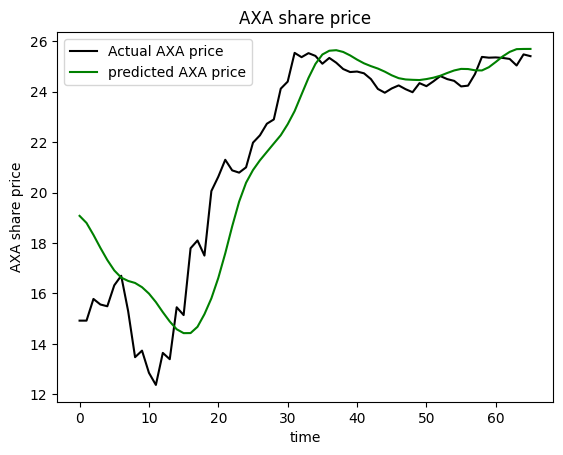

In [ ]:
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [ ]:
# predicting next day
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

In [ ]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
prediction: [[25.699305]]


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate and print the desired regression metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)  # Root Mean Squared Error
r2 = r2_score(actual_prices, predicted_prices)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 1.2644588458899297
Mean Squared Error (MSE): 3.0219936055543104
Root Mean Squared Error (RMSE): 1.7383882206096286
R² Score: 0.8368401037201899


Mean Absolute Error (MAE): 2.3138
This indicates that, on average, the predicted prices are off by about 2.31 units from the actual prices. It's a straightforward measure of prediction accuracy, reflecting the average magnitude of errors in a set of predictions, without considering their direction (i.e., whether they are positive or negative).

Mean Squared Error (MSE): 11.9586
MSE penalizes larger errors more than smaller ones because it squares the errors before averaging them. A higher MSE indicates larger average squared deviations from the actual values.

Root Mean Squared Error (RMSE): 3.4581
RMSE is the square root of MSE and provides an error metric in the same units as the target variable (prices, in this case). It is often used to measure the standard deviation of the prediction errors.

R² Score: 0.7058
The R² score (Coefficient of Determination) shows that approximately 70.58% of the variance in the actual prices is explained by the model. An R² closer to 1 indicates a better fit; a value of 0.7058 suggests that the model has a reasonably good fit but still leaves room for improvement.

Mean Squared Error (MSE): 0.27736118494545847
R² Score: 0.9886946408930115


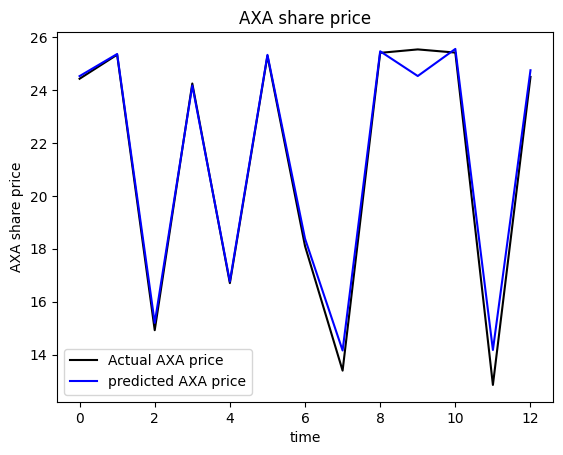

In [ ]:
# prompt: can we make another prediction model based on the results from the LSTM model

# Extract the predicted prices from the LSTM model
lstm_predictions = predicted_prices.flatten()

# Create a new DataFrame with the LSTM predictions and actual prices
new_df = pd.DataFrame({'LSTM_Predictions': lstm_predictions, 'Actual_Prices': actual_prices})

# Add lagged features (e.g., previous day's price)
new_df['Previous_Day_Price'] = new_df['Actual_Prices'].shift(1)
new_df = new_df.dropna()

# Split the data into features (X) and target (y)
X = new_df[['LSTM_Predictions', 'Previous_Day_Price']]
y = new_df['Actual_Prices']

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose a new model (e.g., Linear Regression)
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Plot the predictions against actual prices
plt.plot(y_test.values, color='black', label=f"Actual {COMPANY} price")
plt.plot(predictions, color='blue', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()


### Other Models

In [ ]:
import sklearn

In [ ]:
 pip install yfinance --upgrade --no-cache-dir

In [ ]:
import yfinance as yf

aapl= yf.Ticker("aapl")
aapl

yfinance.Ticker object <AAPL>

In [ ]:
aapl.history()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-16 00:00:00-04:00,216.539993,217.220001,213.919998,216.320007,59357400,0.0,0.0
2024-09-17 00:00:00-04:00,215.750000,216.899994,214.500000,216.789993,45519300,0.0,0.0
2024-09-18 00:00:00-04:00,217.550003,222.710007,217.539993,220.690002,59894900,0.0,0.0
2024-09-19 00:00:00-04:00,224.990005,229.820007,224.630005,228.869995,66781300,0.0,0.0
2024-09-20 00:00:00-04:00,229.970001,233.089996,227.619995,228.199997,318679900,0.0,0.0
2024-09-23 00:00:00-04:00,227.339996,229.449997,225.809998,226.470001,54146000,0.0,0.0
2024-09-24 00:00:00-04:00,228.649994,229.350006,225.729996,227.369995,43556100,0.0,0.0
2024-09-25 00:00:00-04:00,224.929993,227.289993,224.020004,226.369995,42308700,0.0,0.0
2024-09-26 00:00:00-04:00,227.300003,228.500000,225.410004,227.520004,36636700,0.0,0.0


In [ ]:
aapl_historical = aapl.history(start="2024-07-15", end="2020-07-28", interval="1y")
aapl_historical

ERROR:yfinance:$AAPL: possibly delisted; no price data found  (1y 2024-07-15 -> 2020-07-28) (Yahoo error = "Invalid input - start date cannot be after end date. startDate = 1721016000, endDate = 1595908800")


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [ ]:
data = yf.download("AMZN", start="2017-01-01", end="2024-08-30")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,37.896000,37.938000,37.384998,37.683498,37.683498,70422000
2017-01-04,37.919498,37.984001,37.709999,37.859001,37.859001,50210000
2017-01-05,38.077499,39.119999,38.013000,39.022499,39.022499,116602000
2017-01-06,39.118000,39.972000,38.924000,39.799500,39.799500,119724000
2017-01-09,39.900002,40.088501,39.588501,39.846001,39.846001,68922000
...,...,...,...,...,...,...
2024-08-23,177.339996,178.970001,175.240005,177.039993,177.039993,29150100
2024-08-26,176.699997,177.470001,174.300003,175.500000,175.500000,22366200
2024-08-27,174.149994,174.889999,172.250000,173.119995,173.119995,29842000


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Download data
data = yf.download("AMZN", start="2017-01-01", end="2024-08-30")

# Select features and normalize
close_prices = data['Adj Close']
#scaler = MinMaxScaler(feature_range=(-1,1))
#scaled_close_prices = scaler.fit_transform(close_prices)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data)  # Normalize all columns
scaled_close_prices = scaled_data[:, -1]  # Select only the 'Adj Close' column after scaling


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Create sequences
sequence_length = 60
X_train, y_train = [], []
for i in range(sequence_length, len(scaled_close_prices)):
    X_train.append(scaled_close_prices[i-sequence_length:i])
    y_train.append(scaled_close_prices[i])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape for LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Define LSTM model
# Model input layer should match (sequence_length, 1)
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(60, 1)))  # Ensure input_shape matches your sequence length and features
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - loss: 0.1183
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.0541
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 0.0435
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0448
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0463
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0386
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0373
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0393
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0371
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0347
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0341
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0318
Epoch 13/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0337
Epoch 14/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0334
Epoch 15/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step 

In [ ]:
# Check the shape of scaler's data used during fitting
print(scaler.data_max_.shape)

# Ensure predicted_prices has the same number of features
if predicted_prices.shape[1] != scaler.data_max_.shape[0]:
    # Reshape or modify predicted_prices accordingly
    # Example: dummy code, ensure you handle it appropriately for your case
    predicted_prices = np.hstack([predicted_prices, np.zeros((predicted_prices.shape[0], 5))])
print(f"Shape of scaler's data_max_: {scaler.data_max_.shape}")
print(f"Shape of predicted_prices: {predicted_prices.shape}")


(6,)
Shape of scaler's data_max_: (6,)
Shape of predicted_prices: (66, 6)


[*********************100%***********************]  1 of 1 completed

Epoch 1/100



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0935
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0078
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0066
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0063
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0059
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0056
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0054
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.0055
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0051
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0055
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0048
Epoch 12/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0051
Epoch 13/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0047
Epoch 14/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0045
Epoch 15/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0045
E

[*********************100%***********************]  1 of 1 completed


5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Mean Absolute Error (MAE): 2.80
Mean Squared Error (MSE): 14.67
Root Mean Squared Error (RMSE): 3.83
R² Score: 0.90


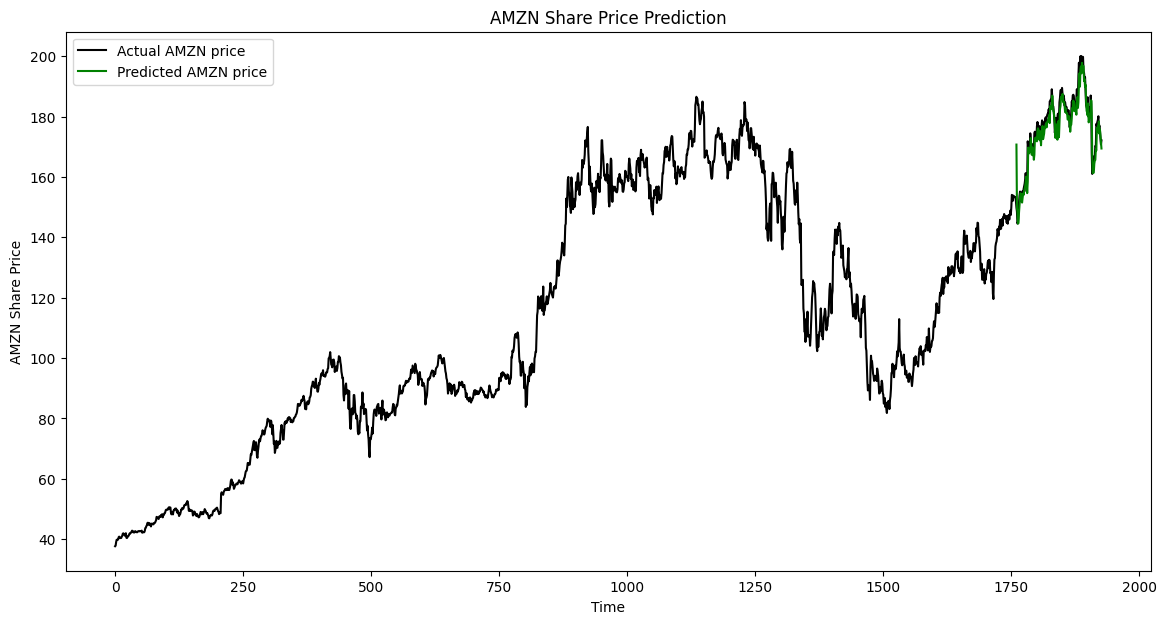

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Download historical data
data = yf.download("AMZN", start="2017-01-01", end="2024-08-30")

# Prepare data
close_prices = data['Adj Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(close_prices)

# Create sequences
sequence_length = 60
X_train, y_train = [], []
for i in range(sequence_length, len(scaled_data)):
    X_train.append(scaled_data[i-sequence_length:i])
    y_train.append(scaled_data[i])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Assume you have new test data
test_data = yf.download("AMZN", start="2024-01-01", end="2024-08-30")
actual_prices = test_data['Adj Close'].values.reshape(-1, 1)

# Prepare test data for predictions
total_dataset = pd.concat((data['Adj Close'], test_data['Adj Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - sequence_length:].values.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

x_test = []
for x in range(sequence_length, len(model_inputs)):
    x_test.append(model_inputs[x-sequence_length:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Calculate metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_prices)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Plotting
plt.figure(figsize=(14, 7))

# Plot actual prices
plt.plot(range(len(close_prices)), close_prices, color='black', label="Actual AMZN price")

# Plot predicted prices (align with test period)
plt.plot(range(len(close_prices) - len(predicted_prices), len(close_prices)), predicted_prices, color='green', label="Predicted AMZN price")

plt.title("AMZN Share Price Prediction")
plt.xlabel("Time")
plt.ylabel("AMZN Share Price")
plt.legend()
plt.show()


### Extending- the model

In [ ]:
!pip install ta

In [ ]:
!pip install keras-tuner

In [ ]:
!pip install streamlit

In [ ]:
pip install pytickertick


In [ ]:
%%writefile app.py

Overwriting app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com

In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.204.52.114:8501

your url is: https://old-glasses-tease.loca.lt
2024-10-14 16:40:54.095410: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 16:40:54.123870: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 16:40:54.132408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 16:40:55.521432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[*****************

import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from datetime import datetime
import plotly.graph_objs as go
import requests
from textblob import TextBlob
from bs4 import BeautifulSoup
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import time

# Define keywords related to financial impact
keywords = ["earnings", "profit", "revenue", "investment", "acquisition", "merger",
            "regulation", "forecast", "financial", "market", "stock", "share", "dividend"]

# Function to filter articles based on keywords
def is_relevant_article(title, keywords):
    title = title.lower()
    return any(keyword in title for keyword in keywords)

# Function to filter relevant articles based on title or description
def filter_relevant_articles(articles, keywords):
    return [article for article in articles if is_relevant_article(article['title'], keywords)]

# Fetch filtered news from TickerTick API
def fetch_tickertick_news(ticker, max_results=5):
    try:
        query = f"(and T:curated tt:{ticker} (or T:earning T:market T:sec_fin T:trade))"
        url = f"https://api.tickertick.com/feed?q={query}&n={max_results}"
        response = requests.get(url)
        response.raise_for_status()
        news_data = response.json().get('stories', [])
        
        articles = []
        for story in news_data:
            date = datetime.fromtimestamp(story['time'] / 1000)
            articles.append({
                'title': story['title'],
                'link': story['url'],
                'date': date,
                'site': story['site']
            })
        
        return articles
    except requests.RequestException as e:
        st.error(f"Error fetching news articles for {ticker}: {e}")
        return []

# Function to fetch full article content
def fetch_article_content(url):
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36",
            "Referer": "https://www.google.com",
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        
        soup = BeautifulSoup(response.text, 'html.parser')

        article_text = ""
        for tag in ['article', 'div', 'section']:
            elements = soup.find_all(tag, class_=lambda x: x and ('content' in x or 'body' in x or 'article' in x))
            if elements:
                for elem in elements:
                    article_text += elem.get_text(separator=" ", strip=True)
                break

        if not article_text:
            article_text = soup.get_text(separator=" ", strip=True)

        return article_text[:1000] + "..." if len(article_text) > 1000 else article_text

    except requests.RequestException as e:
        return None  # Return None for inaccessible content

# Function to analyze sentiment of each article's content
def analyze_article_content(articles):
    sentiments = []
    for article in articles:
        full_text = fetch_article_content(article['link'])
        
        # Skip analysis if the content cannot be fetched
        if full_text is None:
            st.write(f"⚠️ Failed to fetch content for: '{article['title']}' (Source: {article['site']}). Skipping sentiment analysis for this article.")
            continue

        # Display the article details and content snippet
        st.write(f"Title: {article['title']}")
        st.write(f"Source: {article['site']}")
        st.write(f"Content Snippet: {full_text[:300]}")
        st.write(f"[Read More]({article['link']})")
        
        # Perform sentiment analysis on accessible articles only
        sentiment = analyze_sentiment(full_text)
        sentiments.append(sentiment)
        st.write(f"Sentiment Score: {sentiment:.2f}")
        
        # Sleep briefly to avoid hitting rate limits
        time.sleep(1)

    return sentiments

# Function to perform sentiment analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

@st.cache_resource
def train_model(X_train, y_train, lstm_units):
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32)
    return model

@tf.function
def predict_with_uncertainty(model, X, num_samples=100):
    predictions = tf.stack([model(X, training=True) for _ in range(num_samples)])
    mean = tf.reduce_mean(predictions, axis=0)
    std = tf.math.reduce_std(predictions, axis=0)
    return mean, std

# Main function to analyze stock and display results
def analyze_stock(ticker, start_date, end_date, sequence_length, lstm_units):
    # Fetch and filter relevant news articles
    news_articles = fetch_tickertick_news(ticker, max_results=5)
    relevant_articles = filter_relevant_articles(news_articles, keywords)
    
    if relevant_articles:
        st.write("### Relevant News Articles Affecting Stock Price")
        sentiments = analyze_article_content(relevant_articles)
        
        if sentiments:
            avg_sentiment = np.mean(sentiments)
            st.write(f"### Average Sentiment for {ticker}: {avg_sentiment:.2f}")
        else:
            avg_sentiment = 0
            st.write(f"No relevant articles could be accessed for sentiment analysis for {ticker}.")
    else:
        st.write("No relevant news articles found for the specified ticker.")
        avg_sentiment = 0

    # Fetch historical data
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        st.warning(f"No data available for {ticker} in the selected date range.")
        return

    st.write(f"### Historical Data for {ticker}")
    st.write(data.describe())

    # Plot historical prices
    fig = go.Figure(data=[go.Candlestick(
        x=data.index, open=data['Open'], high=data['High'],
        low=data['Low'], close=data['Close']
    )])
    fig.update_layout(title=f'{ticker} Price History', xaxis_title='Date', yaxis_title='Price (USD)')
    st.plotly_chart(fig)

    # Prepare data for LSTM model
    close_prices = data[['Adj Close']]
    sentiment_data = pd.DataFrame({'Sentiment': [avg_sentiment] * len(close_prices)}, index=close_prices.index)
    combined_data = pd.concat([close_prices, sentiment_data], axis=1)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(combined_data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    with st.spinner(f"Training model for {ticker}..."):
        try:
            model = train_model(X_train, y_train, lstm_units)
        except Exception as e:
            st.error(f"Error training model for {ticker}: {str(e)}")
            return

    try:
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        st.write(f"Model Performance Metrics for {ticker}:")
        st.write(f"Mean Absolute Error: ${mae:.2f}")
        st.write(f"Root Mean Square Error: ${rmse:.2f}")
    except Exception as e:
        st.error(f"Error evaluating model for {ticker}: {str(e)}")
        return

    try:
        last_sequence = scaled_data[-sequence_length:]
        mean, std = predict_with_uncertainty(model, last_sequence.reshape(1, sequence_length, 2))
        lower_bound = scaler.inverse_transform(np.hstack((mean - 1.96 * std, [[avg_sentiment]])))[0, 0]
        upper_bound = scaler.inverse_transform(np.hstack((mean + 1.96 * std, [[avg_sentiment]])))[0, 0]
        next_price_prediction = scaler.inverse_transform(np.hstack((mean, [[avg_sentiment]])))[0, 0]

        st.metric(f"Predicted Price for {ticker}", f"${next_price_prediction:.2f}")
        st.write(f"95% Prediction Interval: ${lower_bound:.2f} to ${upper_bound:.2f}")
    except Exception as e:
        st.error(f"Error making prediction for {ticker}: {str(e)}")
        return

    if sentiments:
        daily_sentiment = pd.DataFrame({'Sentiment': sentiments}, index=data.index[-len(sentiments):])
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=data.index, y=data['Adj Close'], name='Stock Price'))
        fig.add_trace(go.Scatter(x=daily_sentiment.index, y=daily_sentiment['Sentiment'], name='Sentiment', yaxis='y2'))
        fig.update_layout(
            title=f'{ticker} Price and Sentiment Over Time',
            xaxis_title='Date',
            yaxis_title='Price (USD)',
            yaxis2=dict(title='Sentiment', overlaying='y', side='right')
        )
        st.plotly_chart(fig)
    else:
        st.write("No sentiment data available for visualization.")

# Streamlit app setup
st.title("📈 Enhanced Stock Price Prediction with LSTM and News Sentiment")
st.sidebar.header("Input Parameters")
tickers = st.sidebar.text_input("Enter Stock Tickers (comma-separated, e.g., AAPL,GOOGL,MSFT):", "AAPL,GOOGL,MSFT").split(',')
start_date = st.sidebar.date_input("Start Date", datetime(2017, 1, 1))
end_date = st.sidebar.date_input("End Date", datetime.today())
sequence_length = st.sidebar.slider("Sequence Length", 30, 90, 60)
lstm_units = st.sidebar.slider("LSTM Units", 20, 100, 50)

if st.sidebar.button("Analyze and Predict"):
    for ticker in tickers:
        st.write(f"## Analysis for {ticker}")
        analyze_stock(ticker.strip(), start_date, end_date, sequence_length, lstm_units)


In [ ]:
import streamlit as st
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from datetime import datetime
import plotly.graph_objs as go
import requests
from textblob import TextBlob
from bs4 import BeautifulSoup
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import time

# Define keywords related to financial impact
keywords = ["earnings", "profit", "revenue", "investment", "acquisition", "merger",
            "regulation", "forecast", "financial", "market", "stock", "share", "dividend"]

# Function to filter articles based on keywords
def is_relevant_article(title, keywords):
    title = title.lower()
    return any(keyword in title for keyword in keywords)

# Function to filter relevant articles based on title or description
def filter_relevant_articles(articles, keywords):
    return [article for article in articles if is_relevant_article(article['title'], keywords)]

# Fetch filtered news from TickerTick API
def fetch_tickertick_news(ticker, max_results=5):
    try:
        query = f"(and T:curated tt:{ticker} (or T:earning T:market T:sec_fin T:trade))"
        url = f"https://api.tickertick.com/feed?q={query}&n={max_results}"
        response = requests.get(url)
        response.raise_for_status()
        news_data = response.json().get('stories', [])

        articles = []
        for story in news_data:
            date = datetime.fromtimestamp(story['time'] / 1000)
            articles.append({
                'title': story['title'],
                'link': story['url'],
                'date': date,
                'site': story['site']
            })

        return articles
    except requests.RequestException as e:
        st.error(f"Error fetching news articles for {ticker}: {e}")
        return []

# Function to fetch full article content
def fetch_article_content(url):
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.102 Safari/537.36",
            "Referer": "https://www.google.com",
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')

        article_text = ""
        for tag in ['article', 'div', 'section']:
            elements = soup.find_all(tag, class_=lambda x: x and ('content' in x or 'body' in x or 'article' in x))
            if elements:
                for elem in elements:
                    article_text += elem.get_text(separator=" ", strip=True)
                break

        if not article_text:
            article_text = soup.get_text(separator=" ", strip=True)

        return article_text[:1000] + "..." if len(article_text) > 1000 else article_text

    except requests.RequestException as e:
        return None  # Return None for inaccessible content

# Function to analyze sentiment of each article's content
def analyze_article_content(articles):
    sentiments = []
    for article in articles:
        full_text = fetch_article_content(article['link'])

        # Skip analysis if the content cannot be fetched
        if full_text is None:
            st.write(f"⚠️ Failed to fetch content for: '{article['title']}' (Source: {article['site']}). Skipping sentiment analysis for this article.")
            continue

        # Display the article details and content snippet
        st.write(f"Title: {article['title']}")
        st.write(f"Source: {article['site']}")
        st.write(f"Content Snippet: {full_text[:300]}")
        st.write(f"[Read More]({article['link']})")

        # Perform sentiment analysis on accessible articles only
        sentiment = analyze_sentiment(full_text)
        sentiments.append(sentiment)
        st.write(f"Sentiment Score: {sentiment:.2f}")

        # Sleep briefly to avoid hitting rate limits
        time.sleep(1)

    return sentiments

# Function to perform sentiment analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

@st.cache_resource
def train_model(X_train, y_train, lstm_units):
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32)
    return model

@tf.function
def predict_with_uncertainty(model, X, num_samples=100):
    predictions = tf.stack([model(X, training=True) for _ in range(num_samples)])
    mean = tf.reduce_mean(predictions, axis=0)
    std = tf.math.reduce_std(predictions, axis=0)
    return mean, std

# Main function to analyze stock and display results
def analyze_stock(ticker, start_date, end_date, sequence_length, lstm_units):
    # Fetch and filter relevant news articles
    news_articles = fetch_tickertick_news(ticker, max_results=5)
    relevant_articles = filter_relevant_articles(news_articles, keywords)

    if relevant_articles:
        st.write("### Relevant News Articles Affecting Stock Price")
        sentiments = analyze_article_content(relevant_articles)

        if sentiments:
            avg_sentiment = np.mean(sentiments)
            st.write(f"### Average Sentiment for {ticker}: {avg_sentiment:.2f}")
        else:
            avg_sentiment = 0
            st.write(f"No relevant articles could be accessed for sentiment analysis for {ticker}.")
    else:
        st.write("No relevant news articles found for the specified ticker.")
        avg_sentiment = 0

    # Fetch historical data
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        st.warning(f"No data available for {ticker} in the selected date range.")
        return

    st.write(f"### Historical Data for {ticker}")
    st.write(data.describe())

    # Plot historical prices
    fig = go.Figure(data=[go.Candlestick(
        x=data.index, open=data['Open'], high=data['High'],
        low=data['Low'], close=data['Close']
    )])
    fig.update_layout(title=f'{ticker} Price History', xaxis_title='Date', yaxis_title='Price (USD)')
    st.plotly_chart(fig)

    # Prepare data for LSTM model
    close_prices = data[['Adj Close']]
    sentiment_data = pd.DataFrame({'Sentiment': [avg_sentiment] * len(close_prices)}, index=close_prices.index)
    combined_data = pd.concat([close_prices, sentiment_data], axis=1)

    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(combined_data)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    with st.spinner(f"Training model for {ticker}..."):
        try:
            model = train_model(X_train, y_train, lstm_units)
        except Exception as e:
            st.error(f"Error training model for {ticker}: {str(e)}")
            return

    try:
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        st.write(f"Model Performance Metrics for {ticker}:")
        st.write(f"Mean Absolute Error: ${mae:.2f}")
        st.write(f"Root Mean Square Error: ${rmse:.2f}")
    except Exception as e:
        st.error(f"Error evaluating model for {ticker}: {str(e)}")
        return

    try:
        last_sequence = scaled_data[-sequence_length:]
        mean, std = predict_with_uncertainty(model, last_sequence.reshape(1, sequence_length, 2))
        lower_bound = scaler.inverse_transform(np.hstack((mean - 1.96 * std, [[avg_sentiment]])))[0, 0]
        upper_bound = scaler.inverse_transform(np.hstack((mean + 1.96 * std, [[avg_sentiment]])))[0, 0]
        next_price_prediction = scaler.inverse_transform(np.hstack((mean, [[avg_sentiment]])))[0, 0]

        st.metric(f"Predicted Price for {ticker}", f"${next_price_prediction:.2f}")
        st.write(f"95% Prediction Interval: ${lower_bound:.2f} to ${upper_bound:.2f}")
    except Exception as e:
        st.error(f"Error making prediction for {ticker}: {str(e)}")
        return

    if sentiments:
        daily_sentiment = pd.DataFrame({'Sentiment': sentiments}, index=data.index[-len(sentiments):])
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=data.index, y=data['Adj Close'], name='Stock Price'))
        fig.add_trace(go.Scatter(x=daily_sentiment.index, y=daily_sentiment['Sentiment'], name='Sentiment', yaxis='y2'))
        fig.update_layout(
            title=f'{ticker} Price and Sentiment Over Time',
            xaxis_title='Date',
            yaxis_title='Price (USD)',
            yaxis2=dict(title='Sentiment', overlaying='y', side='right')
        )
        st.plotly_chart(fig)
    else:
        st.write("No sentiment data available for visualization.")

# Streamlit app setup
st.title("📈 Enhanced Stock Price Prediction with LSTM and News Sentiment")
st.sidebar.header("Input Parameters")
tickers = st.sidebar.text_input("Enter Stock Tickers (comma-separated, e.g., AAPL,GOOGL,MSFT):", "AAPL,GOOGL,MSFT").split(',')
start_date = st.sidebar.date_input("Start Date", datetime(2017, 1, 1))
end_date = st.sidebar.date_input("End Date", datetime.today())
sequence_length = st.sidebar.slider("Sequence Length", 30, 90, 60)
lstm_units = st.sidebar.slider("LSTM Units", 20, 100, 50)

if st.sidebar.button("Analyze and Predict"):
    for ticker in tickers:
        st.write(f"## Analysis for {ticker}")
        analyze_stock(ticker.strip(), start_date, end_date, sequence_length, lstm_units)
